# occupancy prediction - forecasting with `prophet`

> Author: Trevor Bergstrom <br>
> Date: 2022-08-27 <br>
> Kernel: Python 3.10 <br>

## init

In [13]:
import os 
os.chdir('/Users/trevor/Work/1-projects/occupancy-prediction')

import numpy as np
import pandas as pd 
import pathlib 
import prophet

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
DATASTORE = pathlib.Path('datastore')
assert DATASTORE.exists(), f'unable to find datastore at: {DATASTORE}'

# data acquisition

## load

In [9]:
data_path = DATASTORE.joinpath('occ-counts.csv')

df = (
    pd.read_csv(data_path, parse_dates=['timestamp']).rename(columns={'count': 'occ'})
    .query('location == "POP"')
    .query('5 < timestamp.dt.hour < 24')
    .drop(columns=['location', 'capacity', 'subLabel', 'lastUpdate'])
    .reindex(columns=['timestamp', 'occ'])
)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7160 entries, 0 to 22647
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7160 non-null   datetime64[ns]
 1   occ        7160 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 167.8 KB


None

,timestamp,occ
0,2022-03-28 16:02:42.738457,177
3,2022-03-28 16:04:30.367773,184
6,2022-03-28 16:04:53.611084,191
9,2022-03-28 16:11:59.003963,207
12,2022-03-28 16:22:04.569012,227


## feature processing

In [15]:
hourly_occs = (
    df
    .groupby(pd.Grouper(key='timestamp', freq='1H')).occ.mean()
    .reset_index().rename(columns={'timestamp': 'ds', 'occ': 'y'})
)
hourly_occs.head()

,ds,y
0,2022-03-28 16:00:00,204.666667
1,2022-03-28 17:00:00,370.333333
2,2022-03-28 18:00:00,400.500000
3,2022-03-28 19:00:00,415.000000
4,2022-03-28 20:00:00,377.666667


In [17]:
cutover = pd.to_datetime('2022-07-15')
hourly_occs_train = hourly_occs.loc[lambda d: d.ds <= cutover]
hourly_occs_test = hourly_occs.loc[lambda d: d.ds > cutover]

# `prophet`

## train

In [18]:
m = prophet.Prophet()
model = m.fit(hourly_occs_train)

13:26:39 - cmdstanpy - INFO - Chain [1] start processing
13:26:39 - cmdstanpy - INFO - Chain [1] done processing


## predict

In [42]:
forecast = m.predict(hourly_occs).merge(hourly_occs, how='left', on=['ds']).dropna()
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2022-03-28 16:00:00,116.435648,129.156395,305.440596,116.435648,116.435648,97.811552,97.811552,97.811552,105.785271,105.785271,105.785271,-7.973719,-7.973719,-7.973719,0.0,0.0,0.0,214.247200,204.666667
1,2022-03-28 17:00:00,116.433653,181.877381,358.999637,116.433653,116.433653,157.014404,157.014404,157.014404,165.123213,165.123213,165.123213,-8.108809,-8.108809,-8.108809,0.0,0.0,0.0,273.448057,370.333333
2,2022-03-28 18:00:00,116.431659,236.922558,408.813438,116.431659,116.431659,205.696878,205.696878,205.696878,213.851764,213.851764,213.851764,-8.154886,-8.154886,-8.154886,0.0,0.0,0.0,322.128536,400.500000
3,2022-03-28 19:00:00,116.429664,237.366713,424.279600,116.429664,116.429664,214.057577,214.057577,214.057577,222.170130,222.170130,222.170130,-8.112553,-8.112553,-8.112553,0.0,0.0,0.0,330.487241,415.000000
4,2022-03-28 20:00:00,116.427669,194.061727,372.318592,116.427669,116.427669,168.675567,168.675567,168.675567,176.658871,176.658871,176.658871,-7.983304,-7.983304,-7.983304,0.0,0.0,0.0,285.103236,377.666667


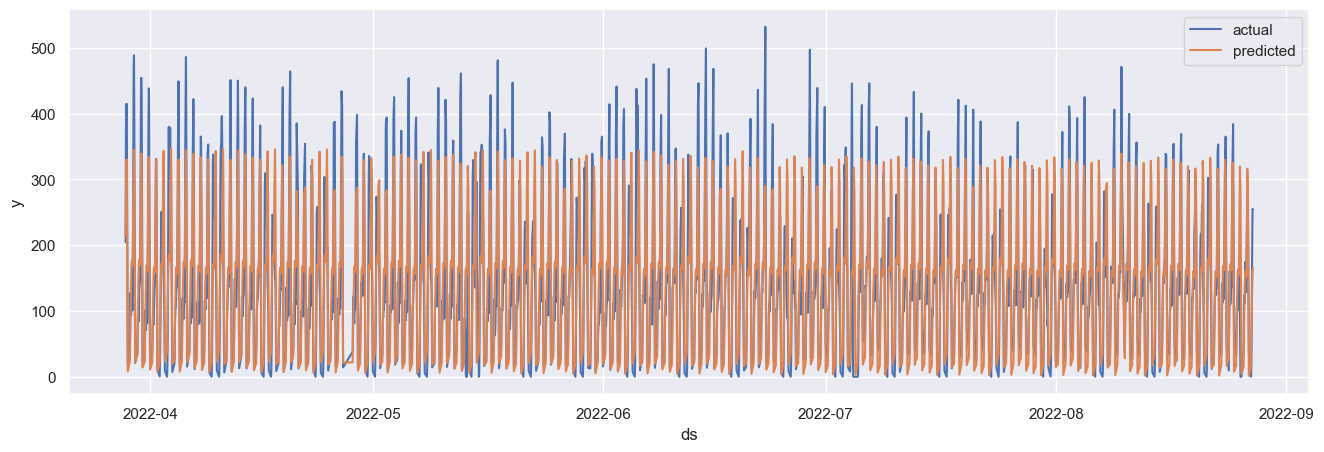

In [43]:
plt.figure(figsize=(16, 5))

sns.lineplot(data=forecast, x='ds', y='y')
sns.lineplot(data=forecast, x='ds', y='yhat')
plt.legend(['actual', 'predicted'])

<AxesSubplot:xlabel='ds'>

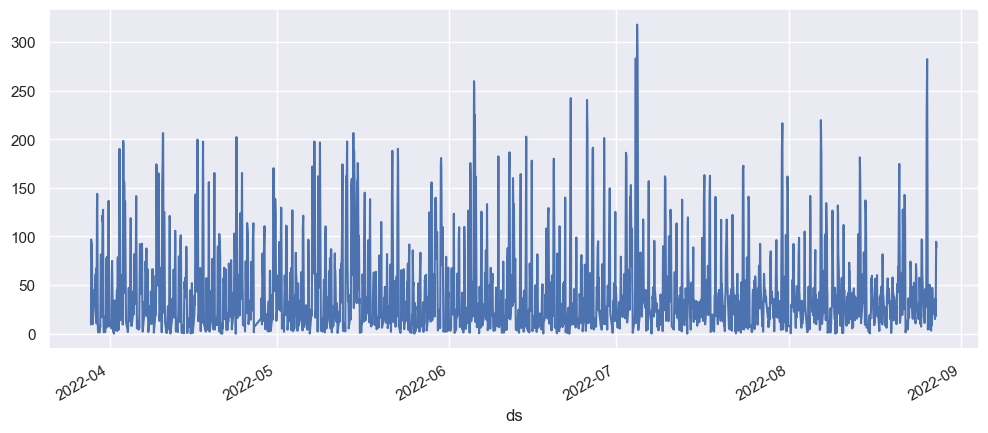

In [44]:
forecast.assign(error = lambda d: (d.yhat - d.y).abs()).set_index('ds').error.plot(figsize=(12, 5))

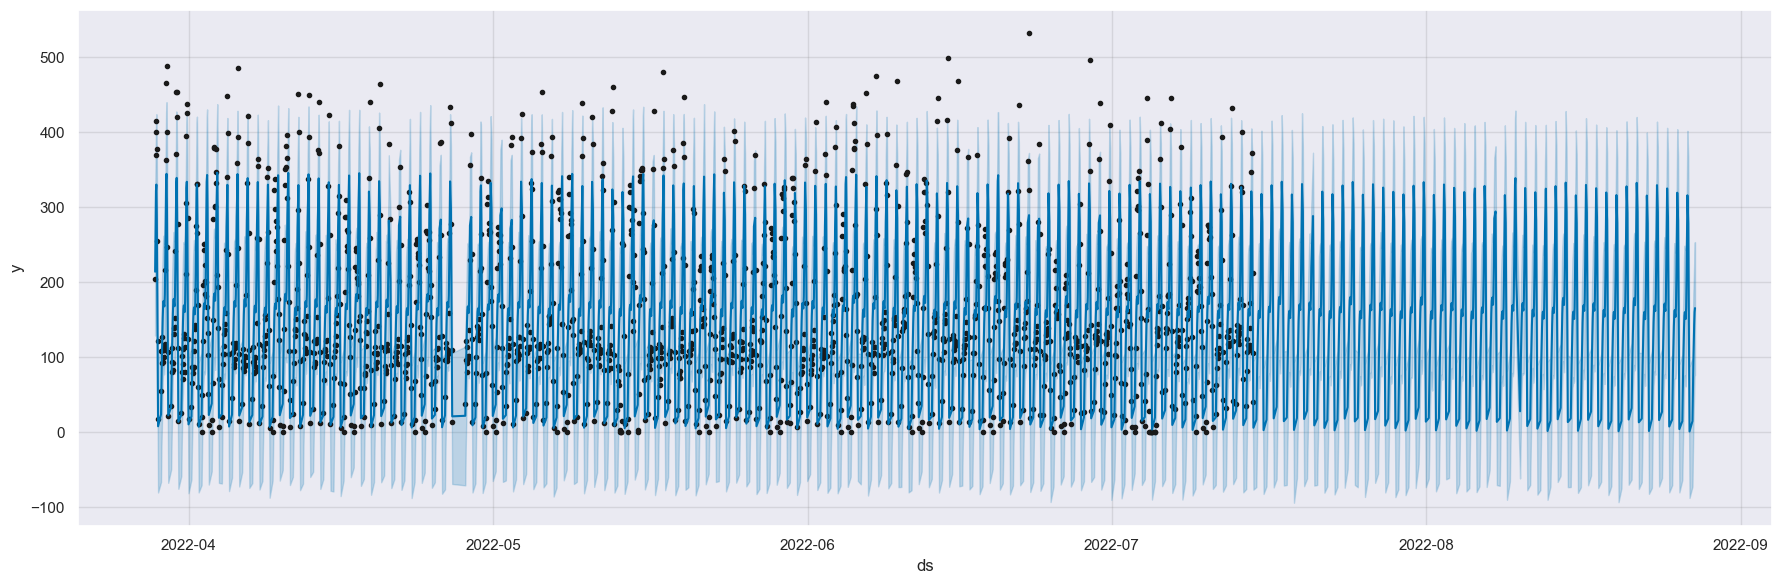

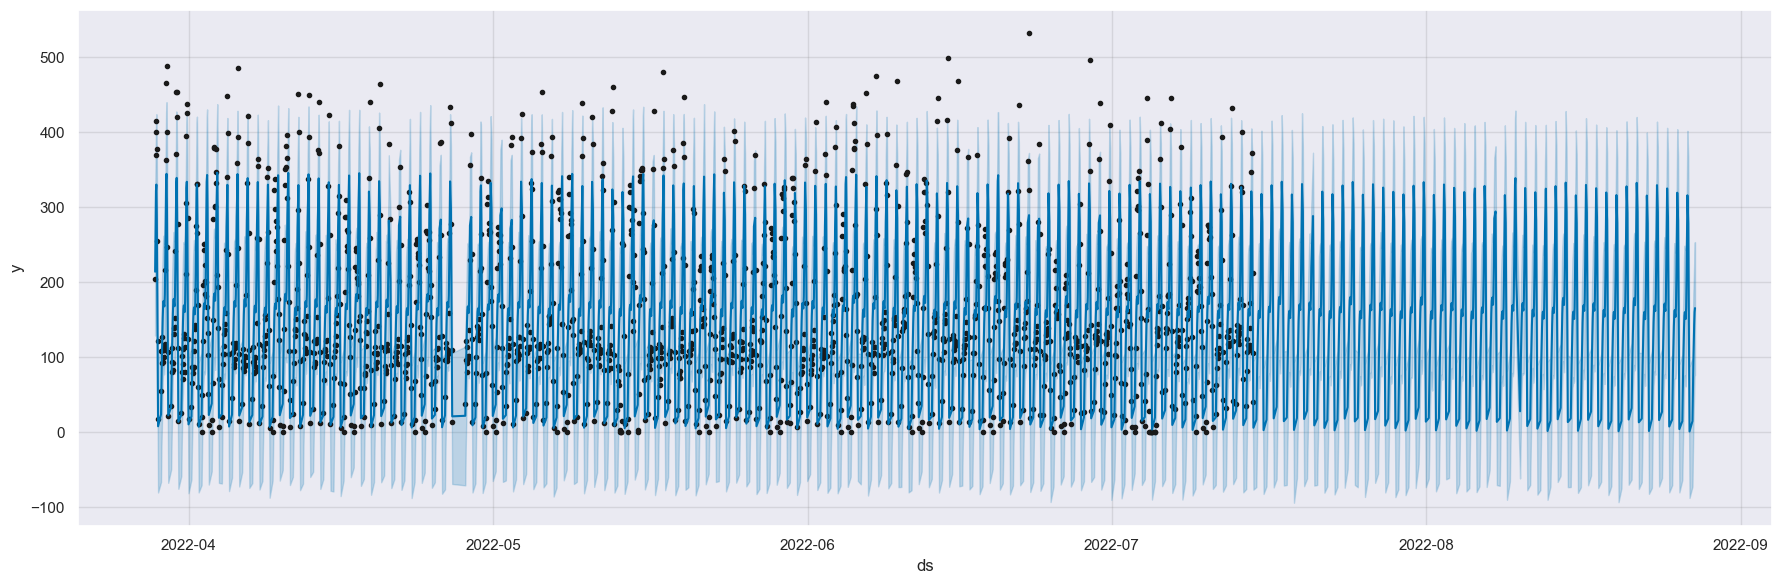

In [45]:
m.plot(forecast, figsize=(18, 6))

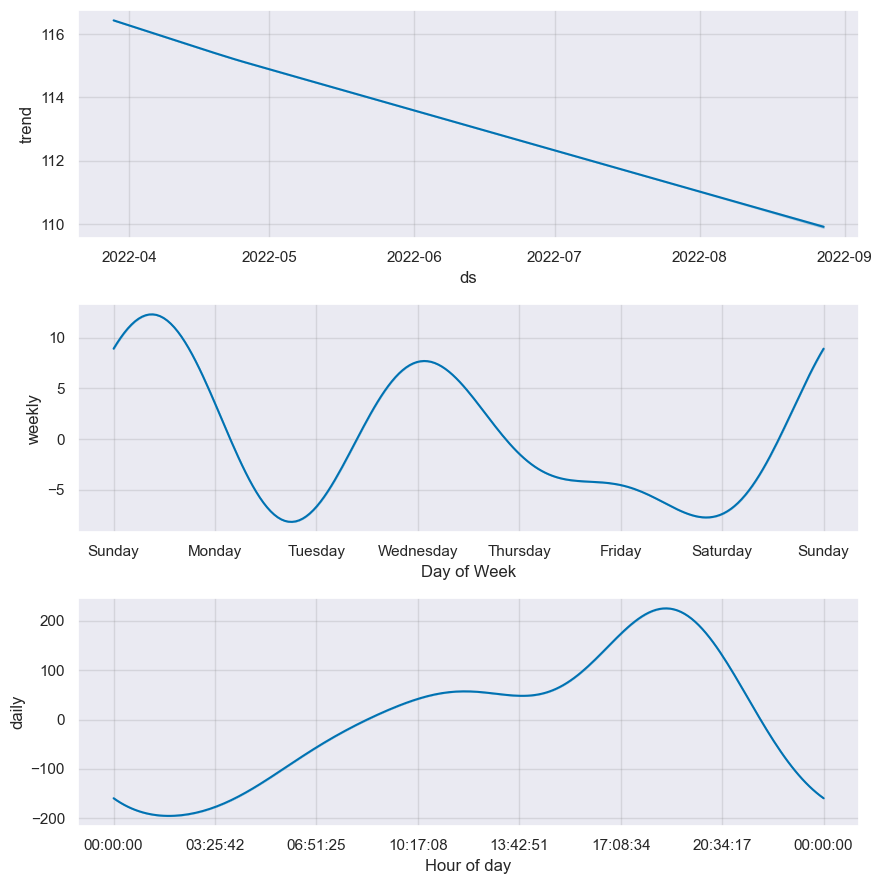

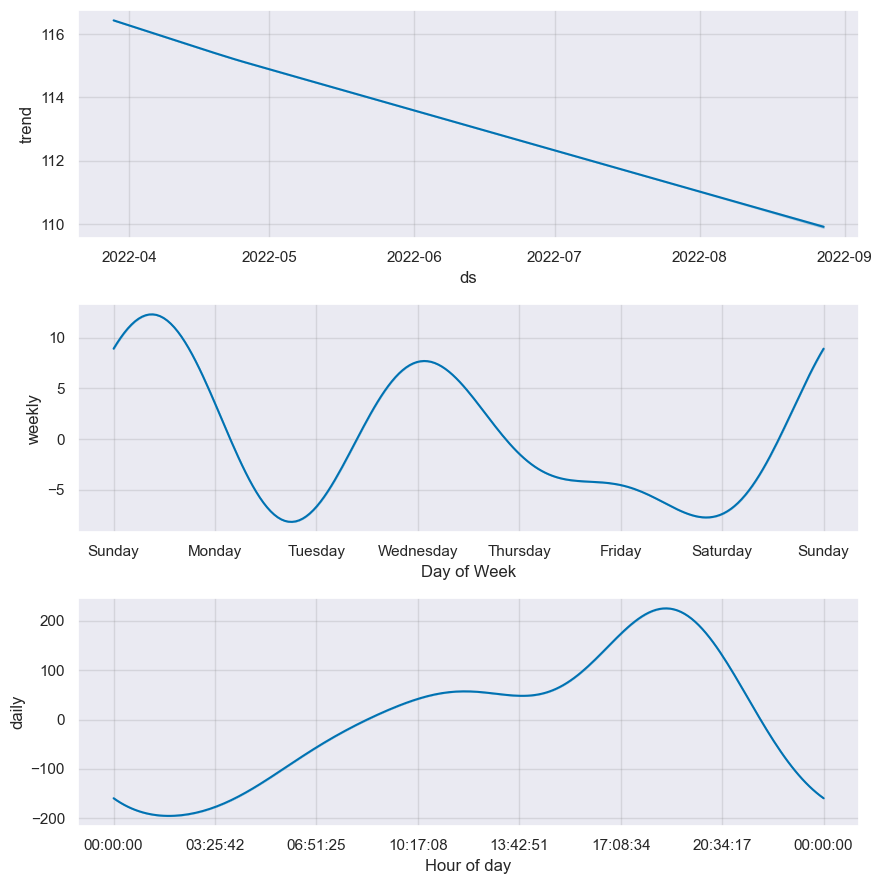

In [46]:
m.plot_components(forecast)